In [72]:
from functions.network_generation import erdos, barabasi_albert, focussed_assort_network_gen, reshuffle_var, write_graph
from functions.metrics import calc_avg_degree, calc_pearson, calc_betweenness, calc_deg_assort, pearson, dos_df, dos_neighbors, check_lonely
from functions.model import mainModel

from functions.visualize import plot_timeseries, set_labels_and_titles, plot_metric_data, plot_grid, nx_network_mp4, point_on_triangle, plot_triangle
import researchhelper.visualize.general_formatting as gf

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json
import re

cmap = plt.get_cmap("tab10")
norm = mcolors.Normalize(vmin=-1, vmax=1)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
with open("input/configs/main_config.json", 'r') as f:
    conf = json.load(f)
conf["network_gen_fn"] = globals().get(conf["network_gen_fn"])
conf_path = f"{conf['network_gen_fn'].__name__}-{conf['e_samples']}es-{conf['n_per_group']}n-{conf['p_rel']}p"

# Energy over time

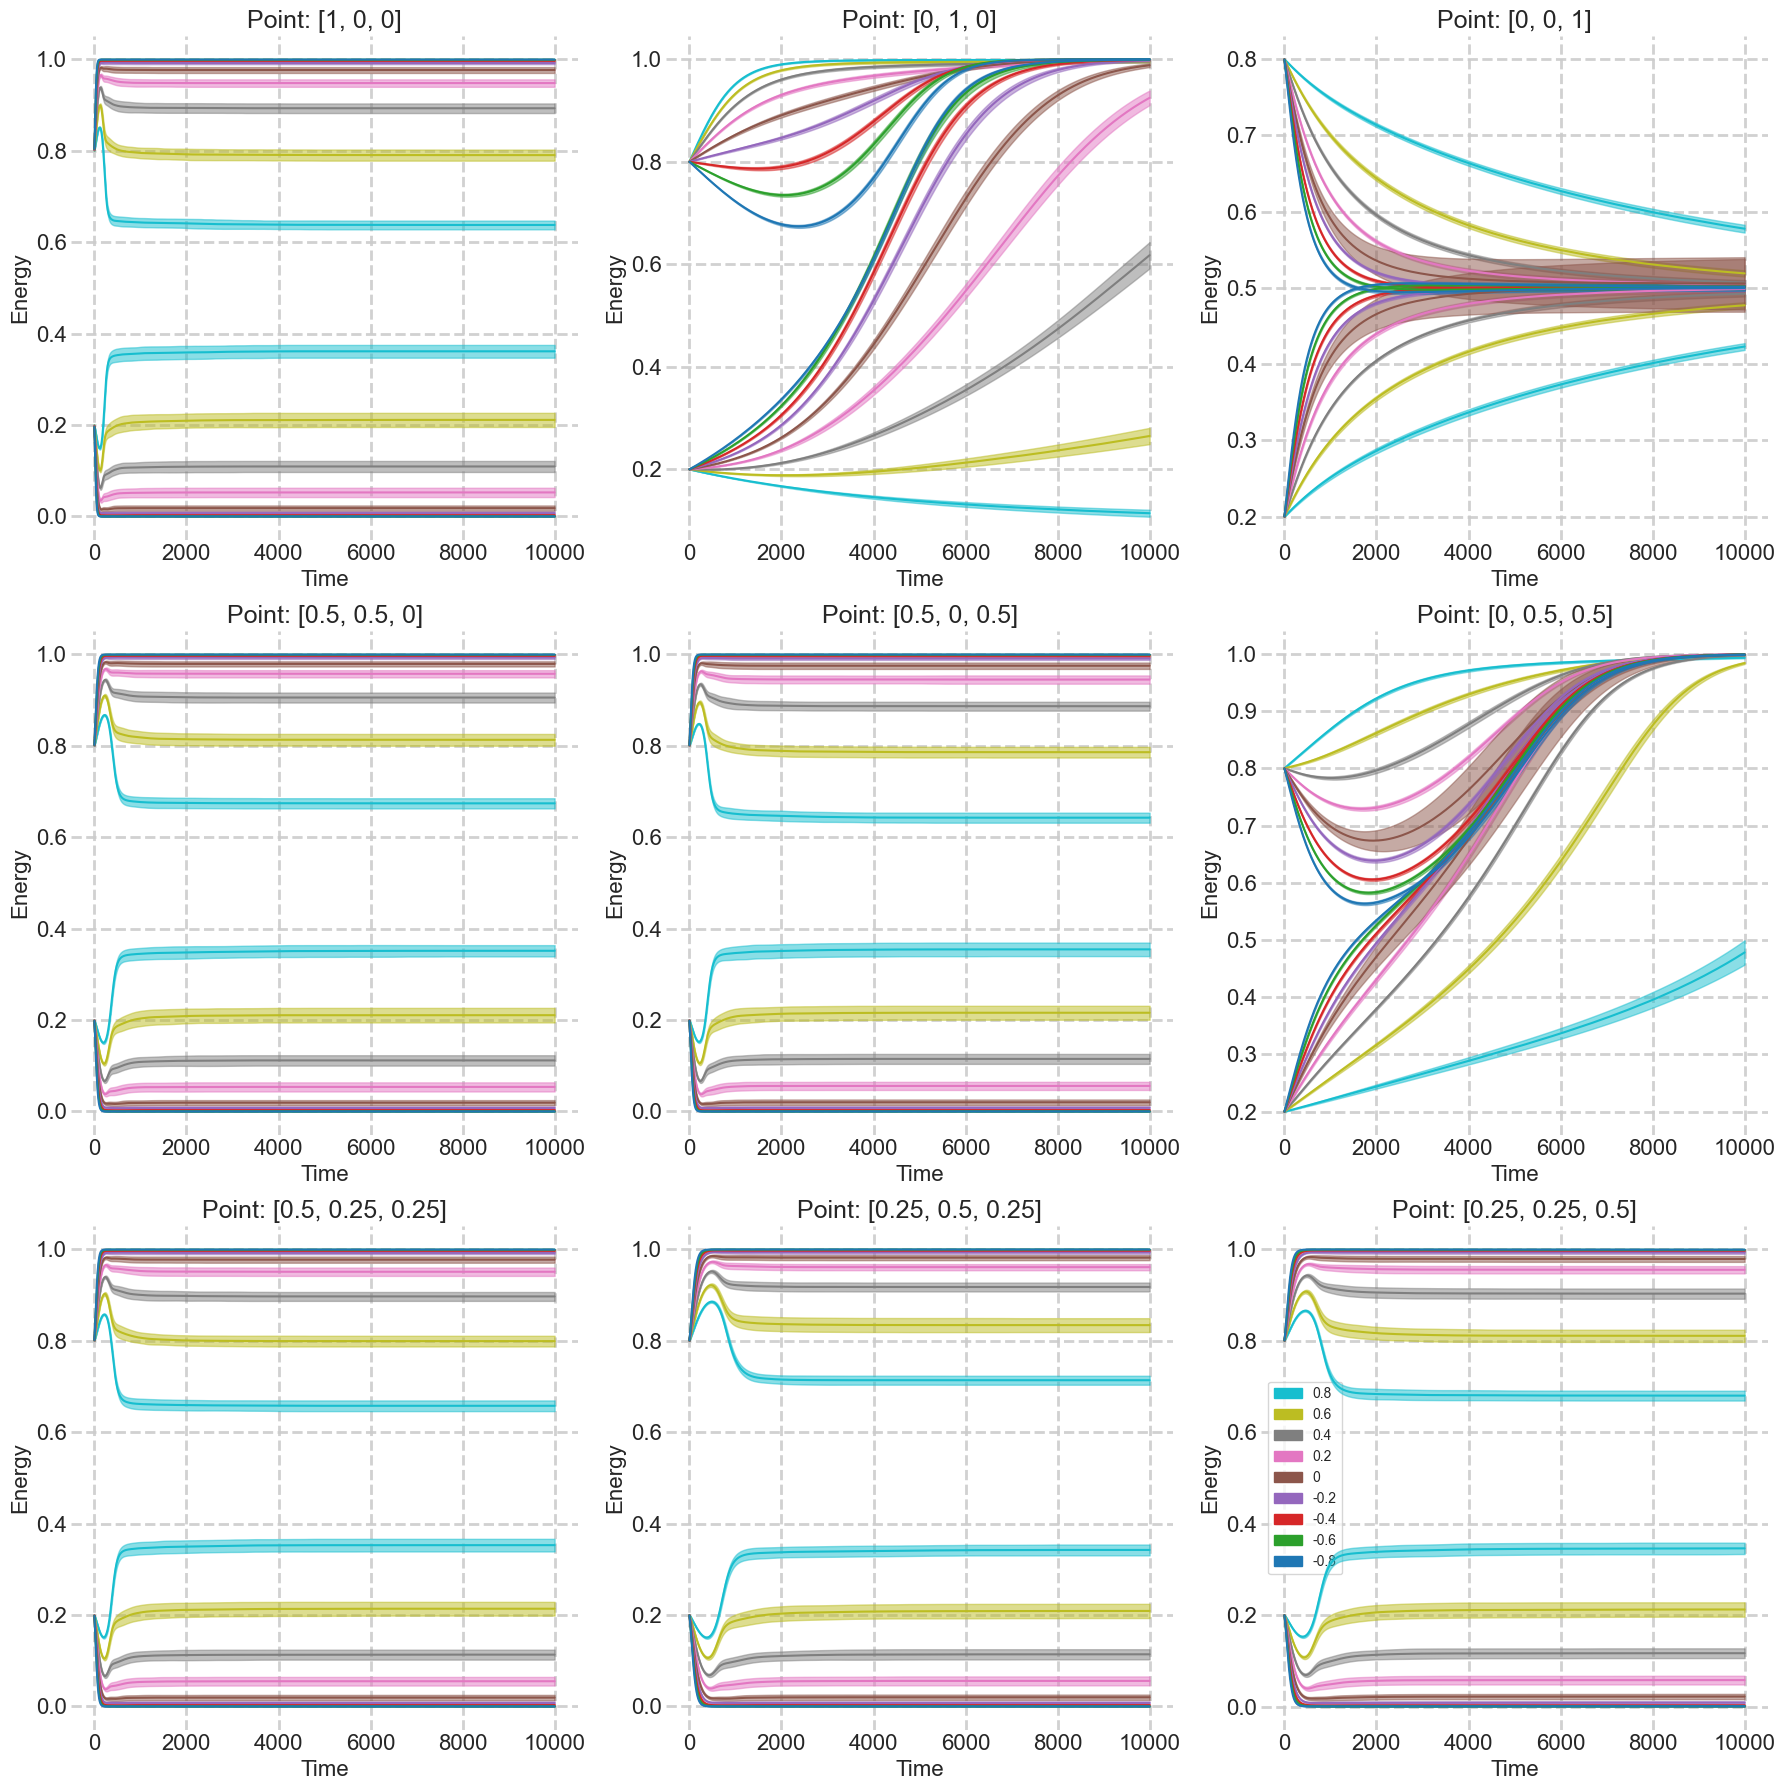

In [74]:
fig, ax = plt.subplots(len(conf["points"]), len(conf["points"][0]), figsize=(6*len(conf["points"][0]), 6*len(conf["points"])))
# fig.patch.set_facecolor('white')
for row_id, row in enumerate(conf["points"]):
    for column_id, point in enumerate(row):
        model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"

        patches = []
        for a in conf["a_s"]:
            dyn_data_path = os.path.join(
                conf["base_path"], conf["dyn_path"], conf_path, str(a), model_path)
            try:
                files = os.listdir(dyn_data_path)
                data_files = {}

                for idx, file in enumerate(files):
                    # Opening JSON file
                    with open(os.path.join(dyn_data_path, file), 'r') as f:
                        # returns JSON object as
                        # a dictionary
                        data_files[idx] = json.load(f)

                non_lonely_mean = []
                lonely_mean = []
                non_lonely_std = []
                lonely_std = []

                for df in data_files:
                    non_lonely_mean.append(data_files[df]["non_lonely_mean"])
                    lonely_mean.append(data_files[df]["lonely_mean"])
                    non_lonely_std.append(data_files[df]["non_lonely_std"])
                    lonely_std.append(data_files[df]["lonely_std"])

                # Uncomment if you want variability between files
                plot_timeseries(ax[row_id, column_id], np.array(non_lonely_mean), a)
                plot_timeseries(ax[row_id, column_id], np.array(lonely_mean), a)

                # Uncomment if you want mean variability within simulations
                # plot_timeseries(ax[row_id, column_id], np.array(non_lonely_mean), a, data_std=np.array(non_lonely_std))
                # plot_timeseries(ax[row_id, column_id], np.array(lonely_mean), a, data_std=np.array(lonely_std))

                patches.append(mpatches.Patch(color=cmap(norm(a)), label=a))
            except FileNotFoundError as e:
                print(e)
            except ValueError as e:
                print(e)
            plt.legend(handles=patches)
            gf.set_frame(ax=ax[row_id, column_id])
            set_labels_and_titles(ax=ax[row_id, column_id], title=f"Point: {point}", xlabel="Time",
                                ylabel="Energy", tick_size=16, label_size=16, title_size=18)

plt.tight_layout()
plt.show()


# Pearson t0 tt

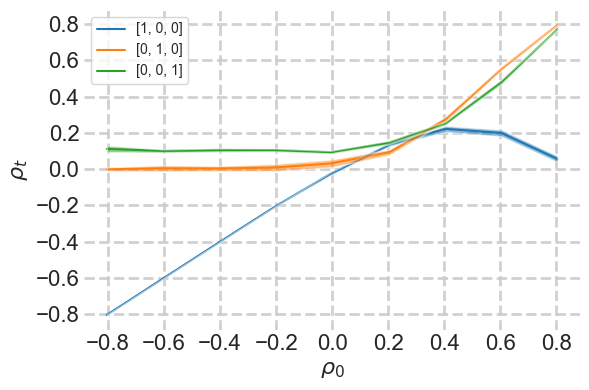

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

pearsons = {}
for row_id, point in enumerate(conf["points"][0]):
    # for column_id, point in enumerate(row):
    model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"
    point = str(point)
    pearsons.setdefault(point, {"x":[], "y":[], "std":[]})
    patches = []
    for a in conf["a_s"]:
        dyn_data_path = os.path.join(
            conf["base_path"], conf["dyn_path"], conf_path, str(a), model_path)

        x, y = [], []
        for idx, file in enumerate(os.listdir(dyn_data_path)):
            # Opening JSON file
            with open(os.path.join(dyn_data_path, file), 'r') as f:
                d = json.load(f)
                x.append(d["pearsons"][0])
                y.append(d["pearsons"][-1])
        # x = np.array(x)
        # y = np.array(y)
        pearsons[point]["x"].append(np.mean(x))
        pearsons[point]["y"].append(np.mean(y))
        pearsons[point]["std"].append(np.std(y))

    ax.plot(pearsons[point]["x"], pearsons[point]["y"], label=point)
    ax.fill_between(pearsons[point]["x"], np.array(pearsons[point]["y"])-np.array(pearsons[point]["std"]),
                np.array(pearsons[point]["y"])+np.array(pearsons[point]["std"]), zorder=10, alpha=0.5)

plt.legend()
gf.set_frame(ax=ax)
set_labels_and_titles(ax=ax, title=f"", xlabel=r"$\rho_0$",
                        ylabel=r"$\rho_t$", tick_size=16, label_size=16, title_size=18)
plt.tight_layout()
plt.show()

# Graph DOS

## Degree distribution over degree of separation

In [130]:
model_path = f"p{'-'.join(str(np.round(p,2)) for p in [0,1,0])}_b{conf['beta']}_sd{conf['sim_dur']}"
t0_assort_dir_path = os.path.join(conf["base_path"], conf["tt_path"], conf_path, str(.6), model_path)
files = os.listdir(t0_assort_dir_path)
G = nx.read_gml(os.path.join(t0_assort_dir_path, files[0]))

In [131]:
dn = dos_neighbors(G, depth=5)

In [132]:
dos_degrees = [[len(dn[node][degree]) for degree in dn[node]] for node in dn]

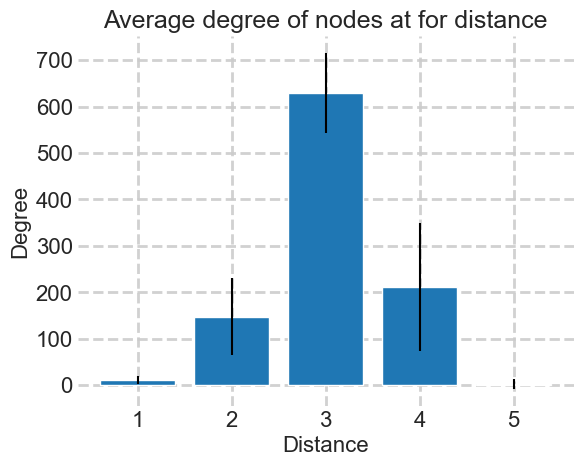

In [134]:
fig, ax = plt.subplots(1,1)
ax.bar(list(range(1,6)),np.array(dos_degrees).mean(axis=0), yerr=np.array(dos_degrees).std(axis=0))
gf.set_frame(ax=ax)
set_labels_and_titles(ax=ax, title=f"Average degree of nodes at for distance", xlabel=r"Distance",
                        ylabel=r"Degree", tick_size=16, label_size=16, title_size=18)

## DOS metric

In [ ]:
def get_threshold_dos(tdata):
    test_gdf = tdata.copy()
    test_gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    tmp = test_gdf[(test_gdf["ego_e"] < 0.5) & (test_gdf["dos"] < 5)].dropna(
        subset=["dos_metric"]).groupby("dos").mean(numeric_only=True).reset_index()
    return tmp[tmp["dos_metric"] < 0]["dos"].min() - 1

In [ ]:
def dos_df(dos_n, energies, states=[0, 1]):
    df = {"ego": [], "dos": [], "ego_e": [], "n_neighbors": []}
    for node in dos_n:
        for degree in dos_n[node]:
            df["ego"].append(node)
            df["dos"].append(degree)
            df["ego_e"].append(energies[node])
            energies_neighbors = [energies[n] for n in dos_n[node][degree]]
            df["n_neighbors"].append(len(energies_neighbors))
            for k in states:
                count = Counter(energies_neighbors)
                df.setdefault(f"alter_e{k}", [])
                df[f"alter_e{k}"].append(count.get(k, 0))
    counts = Counter(energies.values())
    min_energy = min(list(counts.keys()))
    expected_fraction_lonely = counts[min_energy] / len(energies)
    df = pd.DataFrame(df)
    df["alter_fraction_e0"] = df["alter_e0"]/df["n_neighbors"]
    df["difference_random"] = (
        df["alter_fraction_e0"] / expected_fraction_lonely) - 1
    df["dos_metric"] = df["difference_random"].div(
        df.groupby(["ego"])["difference_random"].transform("first"))
    return df

df = dos_df(dos_neighbors(G, depth=4), check_lonely(G))
df

In [91]:
df[df["ego"].isin([str(i) for i in range(3)])]

,ego,dos,ego_e,n_neighbors,alter_e0,alter_e1,alter_fraction_e0,difference_random,dos_metric
0,0,1,0.0,56,33,23,0.589286,0.169218,1.000000
1,0,2,0.0,481,264,217,0.548857,0.089001,0.525956
2,0,3,0.0,459,205,254,0.446623,-0.113843,-0.672761
3,0,4,0.0,4,2,2,0.500000,-0.007937,-0.046901
4,1,1,0.0,8,4,4,0.500000,-0.007937,1.000000
5,1,2,0.0,131,60,71,0.458015,-0.091240,11.496183
6,1,3,0.0,716,361,355,0.504190,0.000377,-0.047486
7,1,4,0.0,145,79,66,0.544828,0.081007,-10.206897
8,2,1,0.0,25,15,10,0.600000,0.190476,1.000000
9,2,2,0.0,285,150,135,0.526316,0.044277,0.232456


In [92]:
get_threshold_dos(df[df["ego"].isin([str(i) for i in range(3)])])

2

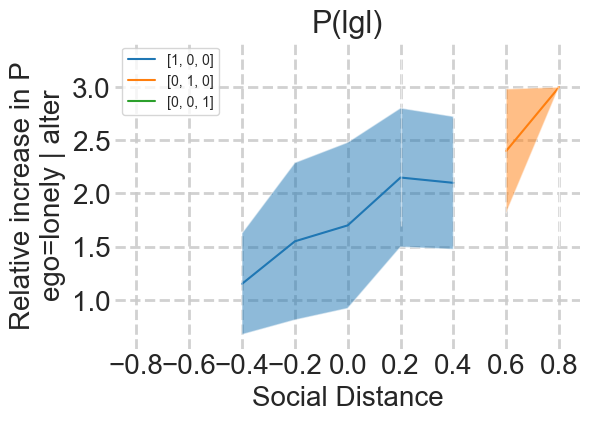

In [79]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
for row_id, point in enumerate(conf["points"][0]):
    # for column_id, point in enumerate(row):
    line_mean = []
    line_std = []
    for a in conf["a_s"]:
        model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"
        t0_assort_dir_path = os.path.join(conf["base_path"], conf["tt_path"], conf_path, str(a), model_path)
        files = os.listdir(t0_assort_dir_path)
        p_data = []
        for file in files:
            G = nx.read_gml(os.path.join(t0_assort_dir_path, file))
            df = dos_df(dos_neighbors(G, depth=4), check_lonely(G))
            p_data.append(get_threshold_dos(df))
        line_mean.append(np.mean(p_data))
        line_std.append(np.std(p_data))
    ax.plot(conf["a_s"], line_mean, label=str(point))
    ax.fill_between(conf["a_s"], np.array(line_mean)-np.array(line_std),
                    np.array(line_mean)+np.array(line_std), zorder=10, alpha=0.5)
plt.legend()
# sns.barplot(x="dos", y="dos_metric",
#             data=df[df["ego_e"] == 0], errorbar=None, alpha=0.4, ax=ax)
# ax.set_ylim((-1, 1))
gf.set_frame(ax=ax)
set_labels_and_titles(ax=ax, title="P(lgl)", xlabel="Social Distance",
                            ylabel="Relative increase in P\nego=lonely | alter")

# Archive

In [8]:
fig, ax = plt.subplots(len(conf["points"]), 2, figsize=(12, 6.5*len(conf["points"])))
fig.patch.set_facecolor('white')
for ax_id, point in enumerate(conf["points"]):
    model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"

    patches = []
    for a in conf["a_s"]:
        dyn_data_path = os.path.join(
            conf["base_path"], conf["dyn_path"], conf_path, str(a), model_path)
        try:
            files = os.listdir(dyn_data_path)
            data_files = {}

            for idx, file in enumerate(files):
                # Opening JSON file
                with open(os.path.join(dyn_data_path, file), 'r') as f:
                    # returns JSON object as
                    # a dictionary
                    data_files[idx] = json.load(f)

            non_lonely_mean = []
            lonely_mean = []
            non_lonely_std = []
            lonely_std = []

            for df in data_files:
                non_lonely_mean.append(data_files[df]["non_lonely_mean"])
                lonely_mean.append(data_files[df]["lonely_mean"])
                non_lonely_std.append(data_files[df]["non_lonely_std"])
                lonely_std.append(data_files[df]["lonely_std"])

            # Uncomment if you want variability between files
            plot_timeseries(ax[ax_id, 0], np.array(non_lonely_mean), a)
            plot_timeseries(ax[ax_id, 0], np.array(lonely_mean), a)

            # Uncomment if you want mean variability within simulations
            # plot_timeseries(ax[ax_id, 0], np.array(non_lonely_mean), a, data_std=np.array(non_lonely_std))
            # plot_timeseries(ax[ax_id, 0], np.array(lonely_mean), a, data_std=np.array(lonely_std))

            # Right fill the data, as sim_length is variable due to window in sim
            pearsons = []
            for df in data_files:
                tdf = data_files[df]["pearsons"]
                pearsons.append(tdf + ([tdf[-1]] * (conf["sim_dur"]+1 - len(tdf))))

            plot_timeseries(ax[ax_id, 1], np.array(pearsons), a)

            patches.append(mpatches.Patch(color=cmap(norm(a)), label=a))
        except FileNotFoundError as e:
            print(e)
        except ValueError as e:
            print(e)
        plt.legend(handles=patches)
        gf.set_frame(ax=ax[ax_id, 0])
        set_labels_and_titles(ax=ax[ax_id, 0], title="Mean energy over time", xlabel="Time",
                              ylabel="Energy", tick_size=16, label_size=16, title_size=18)

        gf.set_frame(ax=ax[ax_id, 1])
        set_labels_and_titles(ax=ax[ax_id, 1], title=f"Pearson dynamics point:{point}", xlabel="Time",
                              ylabel="Pearson correlation", tick_size=16, label_size=16, title_size=18)

plt.tight_layout()
plt.show()


array([0.20086677, 0.20173438, 0.20260402, ..., 0.50871424, 0.50871379,
       0.508713  ])